In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import re

from tqdm.auto import tqdm

from transformers import BertTokenizer, AutoModelForSequenceClassification, get_scheduler

import torch
from torch.utils.data import Dataset, DataLoader


### CONFIGURATION

In [2]:
DATA_PATH = '../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
OUTPUT_PATH = './'
BERT_CHECKPOINT = 'bert-base-uncased'

MAX_LEN = 128
BATCH_SIZE = 32
NUM_CLASSES = 2
LEARNING_RATE = 2e-5
NUM_EPOCHS= 5


pd.set_option('display.max_colwidth', 200)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### UTILS

In [3]:
# For cleaning reviews
def clean_text(text):
    # remove weird spaces
    text =  " ".join(text.split())
    # remove html tags
    text = re.sub(r'<.*?>', '', text)
    return text


# Class for custom dataset
class CustomDataset(Dataset):
    def __init__(self, review, target, tokenizer, max_len, clean_text=None):
        self.clean_text = clean_text
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.review)

    def __getitem__(self, idx):
        y = torch.tensor(self.target[idx], dtype=torch.long)
        X = str(self.review[idx])
        if self.clean_text:
            X = self.clean_text(X)
        
        encoded_X = self.tokenizer(
            X, 
            return_tensors = 'pt', 
            max_length = self.max_len, 
            truncation=True,
            padding = 'max_length'
            )

        return {'input_ids': encoded_X['input_ids'].squeeze(),
                'attention_mask': encoded_X['attention_mask'].squeeze(),
                'labels': y}



# Traing loop for one epoch
def train_epoch(model, dataloader, optimizer, scheduler, device, progress_bar):

    losses = []
    accuracies = []

    model.train()
    for batch in dataloader:

        optimizer.zero_grad()
        batch = {k:v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()

        preds = torch.argmax(outputs.logits, dim=1)
        acc = torch.sum(preds == batch['labels']) / len(preds)
        accuracies.append(acc)
        losses.append(loss)

        progress_bar.update(1)
    
    return torch.tensor(losses, dtype=torch.float).mean().item(), torch.tensor(accuracies).mean().item()


# Evaluation loop
def eval_epoch(model, dataloader, device):
    losses = []
    accuracies = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:

            batch = {k:v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss

            preds = torch.argmax(outputs.logits, dim=1)
            acc = torch.sum(preds == batch['labels']) / len(preds)
            accuracies.append(acc)
            losses.append(loss)
        
        return torch.tensor(losses, dtype=torch.float).mean().item(), torch.tensor(accuracies).mean().item()
    
    


# Evaluation loop
def test(model, dataloader, device):
    y_preds = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:

            batch = {k:v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
        
         
            y_preds.extend( torch.argmax(outputs.logits, dim=1) )
            y_true.extend( batch['labels'])
            
        return y_preds, y_true

### DATA PREPARATION

In [4]:
# read data and remove duplicates
data = (pd.read_csv(DATA_PATH).drop_duplicates())

print(f'Numbers of samples: {len(data)}')
data.head()

Numbers of samples: 49582


,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenl...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...",positive


In [5]:
# transform targets to  integers
data['sentiment'] = data['sentiment'].apply(lambda x: 0 if x == "negative" else 1)
data.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...",1
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...",1
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...",1
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenl...,0
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...",1


In [6]:
# Train, validation and test splits

train_df, test_val_df = train_test_split(data, test_size=0.3, stratify=data['sentiment'], random_state=20)

val_df, test_df = train_test_split(test_val_df, test_size=0.5, stratify=test_val_df['sentiment'], random_state=20)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(f'Number of samples in train set: {len(train_df)}')
print(f'Number of samples in validation set: {len(val_df)}')
print(f'Number of samples in test set: {len(test_df)}')

Number of samples in train set: 34707
Number of samples in validation set: 7437
Number of samples in test set: 7438


In [7]:
tokenizer = BertTokenizer.from_pretrained(BERT_CHECKPOINT)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
dfs = {'train':train_df, 'val':val_df, 'test':test_df}
dataloaders = {}

for df in dfs:
    should_shuffle = True if df == 'train' else False
    dataloaders[df] = DataLoader(
    CustomDataset(dfs[df]['review'],  dfs[df]['sentiment'], tokenizer=tokenizer, max_len=MAX_LEN, clean_text=clean_text),
    batch_size=BATCH_SIZE, shuffle=should_shuffle
    )

In [9]:
# Testing if batch loads properly
for batch in dataloaders['train']:
    print({k:v.shape for k, v in batch.items()})
    break

{'input_ids': torch.Size([32, 128]), 'attention_mask': torch.Size([32, 128]), 'labels': torch.Size([32])}


### TRAINING

In [10]:
# SETUP

# model
model = AutoModelForSequenceClassification.from_pretrained(BERT_CHECKPOINT, num_labels=NUM_CLASSES)

model.to(device)
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

# scheduler
num_training_steps = NUM_EPOCHS * len(dataloaders['train'])
scheduler = get_scheduler(
    'linear',
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)



Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [11]:
# Test 
outputs = model(**{k:v.to(device) for k, v in batch.items()})
print(outputs.loss, outputs.logits.shape)


tensor(0.6312, device='cuda:0', grad_fn=<NllLossBackward0>) torch.Size([32, 2])


In [12]:
# Training, evaluation

progress_bar = tqdm(range(num_training_steps))
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc': []}

best_accuracy = 0
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, dataloaders['train'], optimizer, scheduler, device, progress_bar)
    print(f'Train Loss: {train_loss :.4f} | Accuracy: {train_acc*100 :.2f}')

    val_loss, val_acc = eval_epoch(model, dataloaders['val'], device)
    print(f'Eval Loss: {val_loss :.4f} | Accuracy: {val_acc*100 :.2f}')

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # save best model
    if val_acc > best_accuracy:
        model.save_pretrained(OUTPUT_PATH)
        best_accuracy = val_acc
        
    print('-'*50)

        

  0%|          | 0/5425 [00:00<?, ?it/s]

Train Loss: 0.3123 | Accuracy: 86.24
Eval Loss: 0.2640 | Accuracy: 88.59
--------------------------------------------------
Train Loss: 0.1850 | Accuracy: 92.76
Eval Loss: 0.2632 | Accuracy: 89.30
--------------------------------------------------
Train Loss: 0.0950 | Accuracy: 96.66
Eval Loss: 0.3589 | Accuracy: 88.49
--------------------------------------------------
Train Loss: 0.0438 | Accuracy: 98.66
Eval Loss: 0.4144 | Accuracy: 89.35
--------------------------------------------------
Train Loss: 0.0240 | Accuracy: 99.41
Eval Loss: 0.4637 | Accuracy: 89.34
--------------------------------------------------


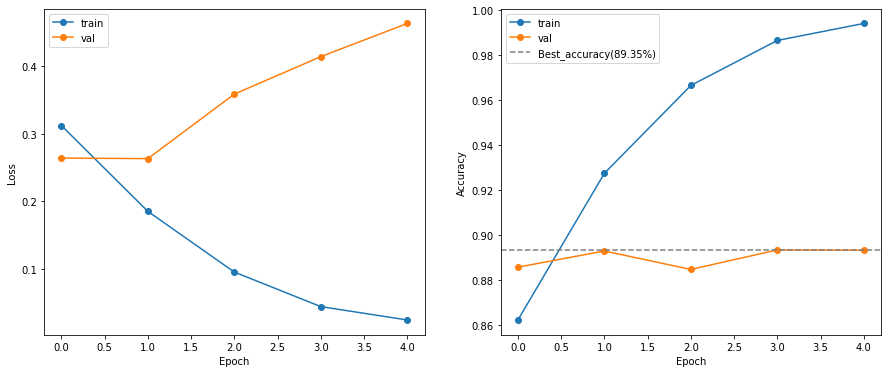

In [13]:
# Plots
x_epochs = list(range(NUM_EPOCHS))
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(x_epochs, history['train_loss'], marker='o', label='train')
plt.plot(x_epochs, history['val_loss'], marker='o', label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_epochs, history['train_acc'], marker='o', label='train')
plt.plot(x_epochs, history['val_acc'], marker='o', label='val')
plt.axhline(best_accuracy, c='grey', ls='--',
            label=f'Best_accuracy({best_accuracy*100 :.2f}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### TEST

In [14]:
y_preds, y_true = test(model,dataloaders['test'], device)

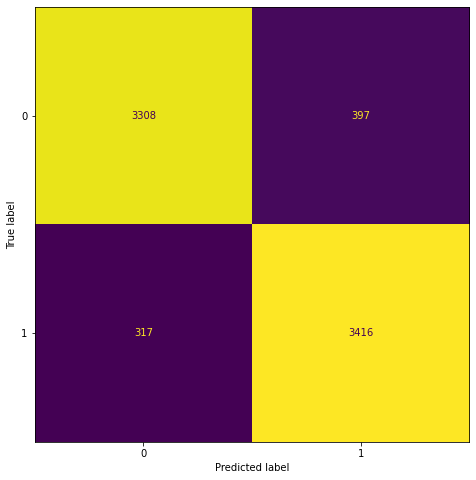

In [15]:
_ , ax = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_predictions(torch.tensor(y_true), torch.tensor(y_preds), ax = ax, colorbar = False);

In [16]:
print(classification_report(torch.tensor(y_true), torch.tensor(y_preds)))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      3705
           1       0.90      0.92      0.91      3733

    accuracy                           0.90      7438
   macro avg       0.90      0.90      0.90      7438
weighted avg       0.90      0.90      0.90      7438

